# UN Datathon 2023
# Monitoring Land Use in Biodiversity Hotspots Affected by Forest Loss
## Sagemaker Geospatial Capabilities and Sentinel-2

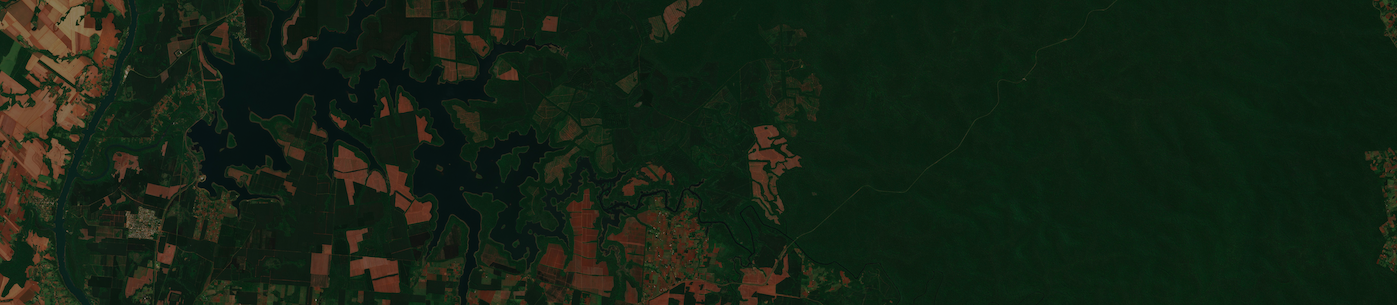

### Green Analytics
Notebook Author: Julieta Millan



This notebook is based on the examples present in the sagemaker geospatial repository from aws: https://github.com/aws/amazon-sagemaker-examples/tree/main/sagemaker-geospatial

 
Specifically, we used 
 - https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-geospatial/brazil-deforestation-monitoring/deforestation-monitoring.ipynb
 - https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-geospatial/dixie-wildfire-damage-assessment/dixie-wildfire-damage-assessment.ipynb
 - https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-geospatial/mount-shasta-glacier-melting-monitoring/mount_shasta_glacier_melt_monitoring.ipynb

<a id='1'></a>

## Setup SageMaker geospatial capabilities

In [2]:
import datetime as dt
import os
import time
from glob import glob
from urllib import request
from urllib.parse import urlparse

import boto3
import cv2
import imageio.v2 as imageio
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import sagemaker
import sagemaker_geospatial_map
import tifffile
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import HTML

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [3]:
session = boto3.Session()
execution_role = sagemaker.get_execution_role()
sg_client = session.client(service_name="sagemaker-geospatial")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


<a id='2'></a>

## Query and access data

Query the geospatial data with area of interest (AOI), time range and cloud cover filter.  In this example we will monitor a location near Novo Progresso, Brazil.  We enter the coordinates for this location, the time that we are interested, and the maximium cloud coverage.  

In [4]:
# Add Misiones coordinates
#{"type":"Polygon","coordinates":[[[-54.529124,-26.113527],[-54.529124,-25.857377],[-54.167948,-25.857377],[-54.167948,-26.113527],[-54.529124,-26.113527]]]}
coords = [[-54.529124,-26.113527],[-54.529124,-25.857377],[-54.167948,-25.857377],[-54.167948,-26.113527],[-54.529124,-26.113527]]
timestart = "2019-01-01T00:00:00Z"
timeend = "2023-09-01T00:00:00Z"
maxclouds = 1  #

In [5]:
dc = sg_client.list_raster_data_collections()
for k in dc["RasterDataCollectionSummaries"]:
    print()
    print(f"Dataset:     {k['Name']}\nDescription: {k['Description']}\nArn:         {k['Arn']}")


Dataset:     Copernicus DEM GLO-30
Description: Copernicus DEM is a Digitial Surface Model which represents the surface of the Earth including buildings, infrastructure, and vegetation. GLO-30 is instance of Copernicus DEM that provides limited worldwide coverage at 30 meters.
Arn:         arn:aws:sagemaker-geospatial:us-west-2:378778860802:raster-data-collection/public/dxxbpqwvu9041ny8

Dataset:     Copernicus DEM GLO-90
Description: Copernicus DEM is a Digitial Surface Model which represents the surface of the Earth including buildings, infrastructure, and vegetation. GLO-90 is instance of Copernicus DEM that provides worldwide coverage at 90 meters.
Arn:         arn:aws:sagemaker-geospatial:us-west-2:378778860802:raster-data-collection/public/p426dk26xzw3pf8p

Dataset:     Landsat Collection 2 Level-2 Science Products
Description: Landsat Collection 2 includes scene-based global Level-2 surface reflectance and surface temperature science products.,
Arn:         arn:aws:sagemaker-ge

In [6]:
search_rdc_args = {
    "Arn": "arn:aws:sagemaker-geospatial:us-west-2:378778860802:raster-data-collection/public/nmqj48dcu3g7ayw8",  # sentinel-2 L2A COG
    "RasterDataCollectionQuery": {
        "AreaOfInterest": {
            "AreaOfInterestGeometry": {"PolygonGeometry": {"Coordinates": [coords]}}
        },
        "TimeRangeFilter": {
            "StartTime": timestart,
            "EndTime": timeend,
        },
        "PropertyFilters": {
            "Properties": [
                {"Property": {"EoCloudCover": {"LowerBound": 0, "UpperBound": maxclouds}}}
            ],
            "LogicalOperator": "AND",
        },
        "BandFilter": ["visual"],
    },
}

tci_urls = []
data_manifests = []
while search_rdc_args.get("NextToken", True):
    search_result = sg_client.search_raster_data_collection(**search_rdc_args)
    if search_result.get("NextToken"):
        data_manifests.append(search_result)
    for item in search_result["Items"]:
        tci_url = item["Assets"]["visual"]["Href"]
        print(tci_url)
        tci_urls.append(tci_url)

    search_rdc_args["NextToken"] = search_result.get("NextToken")

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/21/J/YM/2023/8/S2B_21JYM_20230823_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/21/J/YM/2023/8/S2B_21JYM_20230803_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/21/J/YM/2023/7/S2B_21JYM_20230704_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/21/J/YM/2023/6/S2A_21JYM_20230629_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/21/J/YM/2023/6/S2B_21JYM_20230624_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/21/J/YM/2023/6/S2A_21JYM_20230609_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/21/J/YM/2023/5/S2B_21JYM_20230525_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/21/J/YM/2023/5/S2B_21JYM_20230515_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentine

Great!  We have images that match our area of interest, time range, and cloud filter.  Note that the total number of images found will depend on the data query.  

In [7]:
print(f"total number of results found that match the filter criteria: {len(tci_urls)}")

total number of results found that match the filter criteria: 110


Now, let's download one of the results and plot it in the notebook. This is used as a sanity check to ensure the image covers the area of interest, time range, and cloud coverage. 

Downloaded image: S2B_21JYM_20230803_0_L2A


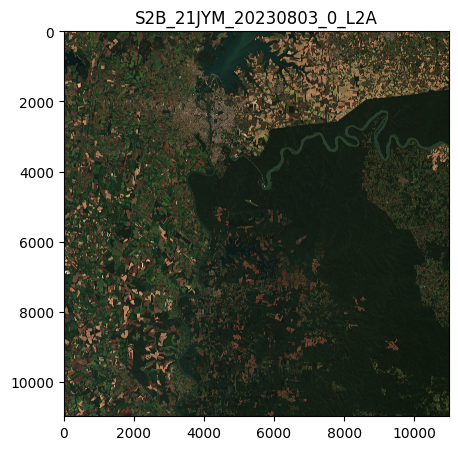

In [8]:
# Check one example.
image_dir = "./images/data"
os.makedirs(image_dir, exist_ok=True)

tci_url = tci_urls[1]
img_id = tci_url.split("/")[-2]
tci_path = image_dir + "/" + img_id + "_TCI.tif"
response = request.urlretrieve(tci_url, tci_path)
print("Downloaded image: " + img_id)

tci = tifffile.imread(tci_path)
fig, ax = plt.subplots(figsize=(5, 5))
plt.title(img_id)
plt.imshow(tci)
plt.show()

<a id='3'></a>
## Start an Earth Observation Job (EOJ) to calculate the Normalized Difference Vegetation Index (NDVI)

First, let's check to see what spectral bands are available in the dataset

In [9]:
sg_client.get_raster_data_collection(
    Arn="arn:aws:sagemaker-geospatial:us-west-2:378778860802:raster-data-collection/public/nmqj48dcu3g7ayw8"
)["ImageSourceBands"]

['coastal',
 'blue',
 'green',
 'red',
 'rededge1',
 'rededge2',
 'rededge3',
 'nir',
 'nir08',
 'nir09',
 'swir16',
 'swir22',
 'aot',
 'wvp',
 'scl']

We can get more information on the bands by visiting the [sentinel website](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial).  Here we will be using band 8 - nir and band 4 - red.  Both of these bands have a 10 m spatial resolution.  The bands will be used to calculate the Normalized Difference Vegetation Index (NDVI).  The index is a ratio between -1 to +1, where values near -1 have low vegetation reflectance and values near +1 have high vegetation reflectance.  Healthy vegetation (chlorophyll) will reflect more near infrared and green light while absorbling more red and blue light.  We will impliment the NDVI calculation using BandMath EOJ job and specify the equation in the EOJ config.  

In [10]:
# Perform land cover segmentation on images returned from the sentinel dataset.
#
# This Earth Observation Job will take ~20 minutes to complete

eoj_input_config = {
    "RasterDataCollectionQuery": {
        "RasterDataCollectionArn": "arn:aws:sagemaker-geospatial:us-west-2:378778860802:raster-data-collection/public/nmqj48dcu3g7ayw8",
        "AreaOfInterest": {
            "AreaOfInterestGeometry": {"PolygonGeometry": {"Coordinates": [coords]}}
        },
        "TimeRangeFilter": {
            "StartTime": timestart,
            "EndTime": timeend,
        },
        "PropertyFilters": {
            "Properties": [
                {"Property": {"EoCloudCover": {"LowerBound": 0, "UpperBound": maxclouds}}}
            ],
            "LogicalOperator": "AND",
        },
    }
}


eoj_config = {
    "BandMathConfig": {
        "CustomIndices": {
            "Operations": [{"Name": "veggie", "Equation": "(nir - red) / (nir + red)"}]
        }
    }
}

response = sg_client.start_earth_observation_job(
    Name="misiones-deforestation",
    InputConfig=eoj_input_config,
    JobConfig=eoj_config,
    ExecutionRoleArn=execution_role,
)

### Monitor the EOJ status.

In [11]:
eoj_arn = response["Arn"]
job_details = sg_client.get_earth_observation_job(Arn=eoj_arn)
{k: v for k, v in job_details.items() if k in ["Arn", "Status", "DurationInSeconds"]}

{'Arn': 'arn:aws:sagemaker-geospatial:us-west-2:037217482728:earth-observation-job/ry49bify4taq',
 'DurationInSeconds': 0,
 'Status': 'INITIALIZING'}

We can also impliment a loop to check on the EOJ status

In [24]:
def EOJwaiter(arn, max_check=1000, max_sleep=60):
    status = None
    print(f"##### Checking Status on EOJ: {arn} #####")
    tic = time.time()

    for i in range(max_check):
        _ = sg_client.get_earth_observation_job(Arn=arn)["Status"]

        if status != _:
            if status is not None:
                print(f"Step Duration: {time.time()-tic:.2f} seconds")
                tic = time.time()

            status = _
            print(status)

            if status == "COMPLETED":
                break
        else:
            print(".", end="", flush=True)
        time.sleep(max_sleep)

In [13]:
EOJwaiter(eoj_arn)

##### Checking Status on EOJ: arn:aws:sagemaker-geospatial:us-west-2:037217482728:earth-observation-job/ry49bify4taq #####
INITIALIZING
Step Duration: 60.78 seconds
IN_PROGRESS
..................................Step Duration: 2117.29 seconds
COMPLETED


<a id='4'></a>

## Visualize EOJ inputs and outputs using the geospatial client

In [15]:
# Creates an instance of the map to add EOJ input/ouput layer
map = sagemaker_geospatial_map.create_map({"is_raster": True})
map.set_sagemaker_geospatial_client(sg_client)

In [16]:
# Render the map
map.render()

SyncWidgetMap(raster={'stacSearchUrl': AnyHttpUrl('https://domain-name/raster', )}, style={'height': '100%', '…

In [23]:
# Visualize AOI
config = {"label": "Novo Progresso AOI"}
aoi_layer = map.visualize_eoj_aoi(Arn=eoj_arn, config=config)
time.sleep(20)

In [24]:
# Visualize input.
time_range_filter = {
    "start_date": timestart,
    "end_date": timeend,
}
config = {"label": "Input"}

input_layer = map.visualize_eoj_input(
    Arn=eoj_arn, config=config, time_range_filter=time_range_filter
)
time.sleep(20)

In [25]:
# Visualize output, EOJ needs to be in completed status.
time_range_filter = {
    "start_date": timestart,
    "end_date": timeend,
}
config = {"preset": "singleBand", "band_name": "veggie"}
output_layer = map.visualize_eoj_output(
    Arn=eoj_arn, config=config, time_range_filter=time_range_filter
)
time.sleep(20)

<a id='5'></a>
## Extract the NDVI band math results

To get the output from the EOJ job we need to export it to s3.  Here we provide an export location and start the export job.  Note that the export job will take ~5 minutes to complete.

In [33]:
sagemaker_session = sagemaker.Session()
s3_bucket_name = sagemaker_session.default_bucket()  # Replace with your own bucket if needed–
# s3_bucket_name = 's3://data-misiones/'
s3_bucket = session.resource("s3").Bucket(s3_bucket_name)
prefix = "eoj_deforestation_ndvi"  # Replace with the S3 prefix desired
export_bucket_and_key = f"s3://{s3_bucket_name}/{prefix}/"

eoj_output_config = {"S3Data": {"S3Uri": export_bucket_and_key}}
export_response = sg_client.export_earth_observation_job(
    Arn=eoj_arn,
    ExecutionRoleArn=execution_role,
    OutputConfig=eoj_output_config,
    ExportSourceImages=False,
)  #

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [29]:
print(f"Data will be exported to:  {export_bucket_and_key}")

Data will be exported to:  s3://sagemaker-us-west-2-037217482728/eoj_deforestation_ndvi/


In [30]:
# Monitor the export job status
export_job_details = sg_client.get_earth_observation_job(Arn=export_response["Arn"])

Again we can impliment a loop to monitor the status of the export

In [31]:
def EOJexportwaiter(arn, max_check=1000, max_sleep=60):
    status = None
    print(f"##### Checking Export Status on EOJ: {arn} #####")
    tic = time.time()

    for i in range(max_check):
        _ = sg_client.get_earth_observation_job(Arn=arn)["ExportStatus"]

        if status != _:
            if status is not None:
                print(f"Step Duration: {time.time()-tic:.2f} seconds")
                tic = time.time()

            status = _
            print(status)

            if status == "SUCCEEDED":
                break
        else:
            print(".", end="", flush=True)
        time.sleep(max_sleep)

In [32]:
EOJexportwaiter(eoj_arn)

##### Checking Export Status on EOJ: arn:aws:sagemaker-geospatial:us-west-2:037217482728:earth-observation-job/ry49bify4taq #####
IN_PROGRESS
......................Step Duration: 1392.26 seconds
SUCCEEDED


<a id='6'></a>
## Measure Vegetation Index

Now with our data exported to s3, let's download the tif masks to the notebook elastic file system (EFS).  Once we download the image we can then calculate the vegetation.  We need to download the images to the file system to be able to read them into memory and to calculate the total area of vegetation.  

In [34]:
# Download band math masks
mask_dir = "./masks/deforestation"
os.makedirs(mask_dir, exist_ok=True)
image_paths = []
for s3_object in s3_bucket.objects.filter(Prefix=prefix).all():
    path, filename = os.path.split(s3_object.key)
    if "output" in path:
        mask_name = mask_dir + "/" + filename
        s3_bucket.download_file(s3_object.key, mask_name)
        print("Downloaded mask: " + mask_name)

# Download source images for visualization
for tci_url in tci_urls:
    url_parts = urlparse(tci_url)
    img_id = url_parts.path.split("/")[-2]
    tci_download_path = image_dir + "/" + img_id + "_TCI.tif"
    cogs_bucket = session.resource(
        "s3", config=Config(signature_version=UNSIGNED, region_name="us-west-2")
    ).Bucket(url_parts.hostname.split(".")[0])
    cogs_bucket.download_file(url_parts.path[1:], tci_download_path)
    print("Downloaded image: " + img_id)

print("Downloads complete.")  #

Downloaded mask: ./masks/deforestation/S2A_21JYM_20190302_0_L2A_veggie.tif
Downloaded mask: ./masks/deforestation/S2A_21JYM_20190411_0_L2A_veggie.tif
Downloaded mask: ./masks/deforestation/S2B_21JYM_20190516_0_L2A_veggie.tif
Downloaded mask: ./masks/deforestation/S2B_21JYM_20190526_0_L2A_veggie.tif
Downloaded mask: ./masks/deforestation/S2B_21JYM_20190705_0_L2A_veggie.tif
Downloaded mask: ./masks/deforestation/S2B_21JYM_20190804_0_L2A_veggie.tif
Downloaded mask: ./masks/deforestation/S2A_21JYM_20190829_0_L2A_veggie.tif
Downloaded mask: ./masks/deforestation/S2B_21JYM_20190923_0_L2A_veggie.tif
Downloaded mask: ./masks/deforestation/S2A_21JYM_20190928_0_L2A_veggie.tif
Downloaded mask: ./masks/deforestation/S2B_21JYM_20191112_0_L2A_veggie.tif
Downloaded mask: ./masks/deforestation/S2B_21JYM_20191112_1_L2A_veggie.tif
Downloaded mask: ./masks/deforestation/S2A_21JYM_20191117_0_L2A_veggie.tif
Downloaded mask: ./masks/deforestation/S2B_21JYM_20191122_0_L2A_veggie.tif
Downloaded mask: ./masks/

### Extract area of vegetation.

In [6]:
image_files = glob("./images/data/*.tif")
mask_files = glob("./masks/deforestation/*.tif")
image_files.sort(key=lambda x: x.split('JYM_')[1])
mask_files.sort(key=lambda x: x.split('JYM_')[1])

In [8]:
overlay_dir = "./masks/veg-index-overlay"
os.makedirs(overlay_dir, exist_ok=True)

veg_areas = []
mask_dates = []
thresh = 0.4  # https://www.usgs.gov/special-topics/remote-sensing-phenology/science/ndvi-foundation-remote-sensing-phenology

for image_file, mask_file in zip(image_files, mask_files):
    print(image_file, mask_file)
    image_id = image_file.split('/')[-1].split("_TCI")[0]
    print(image_id)
    mask_id = mask_file.split("/")[-1].split("_veggie.tif")[0]
    mask_date = mask_id.split("_")[2]
    if image_id == mask_id:
        print(image_id)
        mask_dates.append(mask_date)
        image = tifffile.imread(image_file)  # (10980 x 10980 x 3)
        image_ds = cv2.resize(
            image, (2000, 2000), interpolation=cv2.INTER_LINEAR
        )  # (2000 x 2000 x 3)
        mask = tifffile.imread(mask_file)  # 10980 x 10980 (10 m per pixel)
        veg_mask = (mask > thresh).astype(np.uint8)
        veg_mask = veg_mask[
            2000:, :
        ]  # sample image to remove missing path in the north west corner
        veg_area = (
            veg_mask.sum() * 10 * 10 / (1000 * 1000)
        )  # calculate the surface area, 10m per pixel
        veg_areas.append(veg_area)

        cmap = matplotlib.colors.ListedColormap(["red", "green"])
        f, axarr = plt.subplots(1, 2, figsize=(12, 5))
        axarr[0].imshow(image[2000:, :])
        axarr[0].axis("off")
        axarr[1].imshow(veg_mask, cmap=cmap)
        axarr[1].axis("off")

        f.suptitle(
            f"{image_id}\nTotal Area = {veg_area:.1f} sq km\nDate = {mask_date[0:4]}-{mask_date[4:6]}-{mask_date[6:8]} "
        )
        overlay_file = overlay_dir + "/" + mask_date + ".png"
        f.savefig(overlay_file, dpi=80, bbox_inches="tight")
        plt.close()

./images/data/S2A_21JYM_20190302_0_L2A_TCI.tif ./masks/deforestation/S2A_21JYM_20190302_0_L2A_veggie.tif
S2A_21JYM_20190302_0_L2A
S2A_21JYM_20190302_0_L2A
./images/data/S2A_21JYM_20190411_0_L2A_TCI.tif ./masks/deforestation/S2A_21JYM_20190411_0_L2A_veggie.tif
S2A_21JYM_20190411_0_L2A
S2A_21JYM_20190411_0_L2A
./images/data/S2B_21JYM_20190516_0_L2A_TCI.tif ./masks/deforestation/S2B_21JYM_20190516_0_L2A_veggie.tif
S2B_21JYM_20190516_0_L2A
S2B_21JYM_20190516_0_L2A
./images/data/S2B_21JYM_20190526_0_L2A_TCI.tif ./masks/deforestation/S2B_21JYM_20190526_0_L2A_veggie.tif
S2B_21JYM_20190526_0_L2A
S2B_21JYM_20190526_0_L2A
./images/data/S2B_21JYM_20190705_0_L2A_TCI.tif ./masks/deforestation/S2B_21JYM_20190705_0_L2A_veggie.tif
S2B_21JYM_20190705_0_L2A
S2B_21JYM_20190705_0_L2A
./images/data/S2B_21JYM_20190804_0_L2A_TCI.tif ./masks/deforestation/S2B_21JYM_20190804_0_L2A_veggie.tif
S2B_21JYM_20190804_0_L2A
S2B_21JYM_20190804_0_L2A
./images/data/S2A_21JYM_20190829_0_L2A_TCI.tif ./masks/deforestation/S

In [9]:
HTML('<img src="./masks/veg-index-overlay/20190302.png">')

Now let's split the data by year so we can compare 2019, 2020, 2021, 2022 and 2023. 

In [12]:
a = []
t = []
years = ['2019',"2020", "2021", "2022", '2023']
for y in years:
    a_ = []
    t_ = []
    for i, m in enumerate(mask_dates):
        if m[0:4] == y:
            t_.append(dt.datetime.strptime("1900" + m[4:], "%Y%m%d").date())
            a_.append(veg_areas[i])

    a.append(a_)
    t.append(t_)

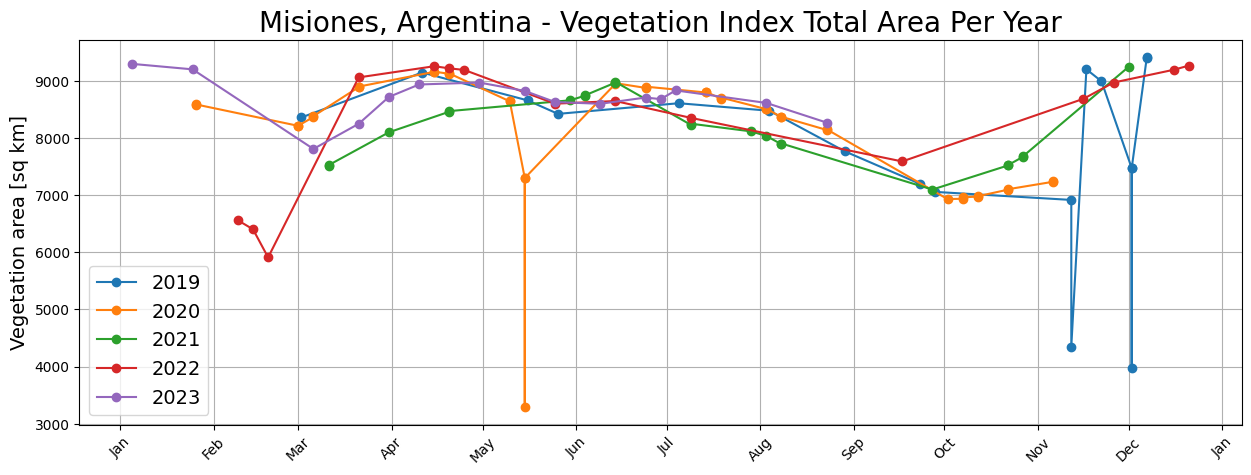

In [14]:
plt.figure(figsize=(15, 5))
plt.title("Misiones, Argentina - Vegetation Index Total Area Per Year", fontsize=20)
plt.xticks(rotation=45)
plt.ylabel("Vegetation area [sq km]", fontsize=14)
plt.plot(t[0], a[0], marker="o", label="2019")
plt.plot(t[1], a[1], marker="o", label="2020")
plt.plot(t[2], a[2], marker="o", label="2021")
plt.plot(t[3], a[3], marker="o", label="2022")
plt.plot(t[4], a[4], marker="o", label="2023")
# Make ticks on occurrences of each month:
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.grid("on")
plt.legend(loc="best", fontsize=14)
plt.show()

The plot above was produced using geospatial images alone.  We can monitor how the total area of the vegetation index is changing over time and compare this to previous years.  In this plot we show how year 2019, 2020, 2021, 2022 and 2023 are slightly different.  There is a clear seasonal trend where the spring vegetation decreases as we approach fall / winter.  As deforestation continues we see the yearly curves move down (less area) each year. Note that the same number of images for each year are different.  This is due to the cloud filter where some of the images acquired during the time range of interest did not meet the cloud coverage constraints. The pronopunced drops in certain places are due to some wrongly cropped images.

In [ ]:
### In the gif with all the images, we can see a very hight deforestation on the left of the image, 
# corresponding to Paraguay, and slight deforestation in Misiones

In [15]:
frames = []
filenames = glob("./masks/veg-index-overlay/*.png")
filenames.sort()

for filename in filenames:
    frames.append(imageio.imread(filename))
imageio.mimsave("deforestation.gif", frames, duration=1)

In [99]:
HTML('<img src="./deforestation.gif">')

## Start an Earth Observation Job (EOJ) to identify the land cover types in the area

In [78]:
# Perform land cover segmentation on images returned from the sentinel dataset.
eoj_input_config = {
    "RasterDataCollectionQuery": {
        "RasterDataCollectionArn": "arn:aws:sagemaker-geospatial:us-west-2:378778860802:raster-data-collection/public/nmqj48dcu3g7ayw8",
        "AreaOfInterest": {
            "AreaOfInterestGeometry": {
                "PolygonGeometry": {
                    "Coordinates": [coords]
                }
            }
        },
        "TimeRangeFilter": {
            "StartTime": timestart,
            "EndTime": timeend,
        },
        "PropertyFilters": {
            "Properties": [{"Property": {"EoCloudCover": {"LowerBound": 0, "UpperBound": maxclouds}}}],
            "LogicalOperator": "AND",
        },
    }
}
eoj_config = {"LandCoverSegmentationConfig": {}}

response = sg_client.start_earth_observation_job(
    Name="misiones-landcover",
    InputConfig=eoj_input_config,
    JobConfig=eoj_config,
    ExecutionRoleArn=execution_role,
)

In [79]:
eoj_arn = response["Arn"]
job_details = sg_client.get_earth_observation_job(Arn=eoj_arn)
{k: v for k, v in job_details.items() if k in ["Arn", "Status", "DurationInSeconds"]}

{'Arn': 'arn:aws:sagemaker-geospatial:us-west-2:037217482728:earth-observation-job/uri8dq28ubyi',
 'DurationInSeconds': 0,
 'Status': 'INITIALIZING'}

In [80]:
EOJwaiter(eoj_arn)

##### Checking Status on EOJ: arn:aws:sagemaker-geospatial:us-west-2:037217482728:earth-observation-job/uri8dq28ubyi #####
INITIALIZING
Step Duration: 61.20 seconds
IN_PROGRESS
.........................................................Step Duration: 3506.00 seconds
COMPLETED


### Extract the land cover segmentation results

In [81]:
sagemaker_session = sagemaker.Session()
s3_bucket_name = sagemaker_session.default_bucket()  # Replace with your own bucket if needed
s3_bucket = session.resource("s3").Bucket(s3_bucket_name)
prefix = "eoj_landcover"  # Replace with the S3 prefix desired
export_bucket_and_key = f"s3://{s3_bucket_name}/{prefix}/"

eoj_output_config = {"S3Data": {"S3Uri": export_bucket_and_key}}
export_response = sg_client.export_earth_observation_job(
    Arn=eoj_arn,
    ExecutionRoleArn=execution_role,
    OutputConfig=eoj_output_config,
    ExportSourceImages=False,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [82]:
# Monitor the export job status
export_job_details = sg_client.get_earth_observation_job(Arn=export_response["Arn"])
{k: v for k, v in export_job_details.items() if k in ["Arn", "ExportStatus"]}

{'Arn': 'arn:aws:sagemaker-geospatial:us-west-2:037217482728:earth-observation-job/uri8dq28ubyi',
 'ExportStatus': 'IN_PROGRESS'}

### Visualize EOJ inputs and outputs in FourSquare Studio

In [83]:
# Creates an instance of the map to add EOJ input/ouput layer
map = sagemaker_geospatial_map.create_map({"is_raster": True})
map.set_sagemaker_geospatial_client(sg_client)
# Render the map
map.render()

SyncWidgetMap(raster={'stacSearchUrl': AnyHttpUrl('https://domain-name/raster', )}, style={'height': '100%', '…

In [85]:
# Visualize AOI
config = {"label": "Misiones AOI"}
aoi_layer = map.visualize_eoj_aoi(Arn=eoj_arn, config=config)

In [86]:
# Visualize input after EOJ has completed.
time_range_filter = {"start_date": timestart, "end_date": timeend}
config = {"label": "Input"}
input_layer = map.visualize_eoj_input(
    Arn=eoj_arn, config=config, time_range_filter=time_range_filter
)

In [87]:
# Visualize output, EOJ needs to be in completed status.
time_range_filter = {"start_date": timestart, "end_date": timeend}
config = {"preset": "singleBand", "band_name": "mask"}
output_layer = map.visualize_eoj_output(
    Arn=eoj_arn, config=config, time_range_filter=time_range_filter
)

In [88]:
# Download land cover masks
mask_dir = "./masks/land-cover"
os.makedirs(mask_dir, exist_ok=True)
image_paths = []
for s3_object in s3_bucket.objects.filter(Prefix=prefix).all():
    path, filename = os.path.split(s3_object.key)
    if (filename.endswith(".tif")):
        mask_name = mask_dir + "/" + filename
        s3_bucket.download_file(s3_object.key, mask_name)
        print("Downloaded mask: " + mask_name)

Downloaded mask: ./masks/land-cover/S2A_21JYM_20190302_0_L2A.tif
Downloaded mask: ./masks/land-cover/S2A_21JYM_20190411_0_L2A.tif
Downloaded mask: ./masks/land-cover/S2B_21JYM_20190516_0_L2A.tif
Downloaded mask: ./masks/land-cover/S2B_21JYM_20190526_0_L2A.tif
Downloaded mask: ./masks/land-cover/S2B_21JYM_20190705_0_L2A.tif
Downloaded mask: ./masks/land-cover/S2B_21JYM_20190804_0_L2A.tif
Downloaded mask: ./masks/land-cover/S2A_21JYM_20190829_0_L2A.tif
Downloaded mask: ./masks/land-cover/S2B_21JYM_20190923_0_L2A.tif
Downloaded mask: ./masks/land-cover/S2A_21JYM_20190928_0_L2A.tif
Downloaded mask: ./masks/land-cover/S2B_21JYM_20191112_0_L2A.tif
Downloaded mask: ./masks/land-cover/S2B_21JYM_20191112_1_L2A.tif
Downloaded mask: ./masks/land-cover/S2A_21JYM_20191117_0_L2A.tif
Downloaded mask: ./masks/land-cover/S2B_21JYM_20191122_0_L2A.tif
Downloaded mask: ./masks/land-cover/S2B_21JYM_20191202_0_L2A.tif
Downloaded mask: ./masks/land-cover/S2B_21JYM_20191202_2_L2A.tif
Downloaded mask: ./masks/

In [89]:
image_files = glob("./images/data/*.tif")
mask_files = glob(mask_dir + "/*.tif")
image_files.sort(key=lambda x: x.split("JYM_")[1])
mask_files.sort(key=lambda x: x.split("JYM_")[1])

In [90]:
# {
# 0: "No_data",
# 1: "Saturated_or_defective",
# 2: "Dark_area_pixels",
# 3: "Cloud_shadows",
# 4: "Vegetation",
# 5: "Not_vegetated",
# 6: "Water",
# 7: "Unclassified",
# 8: "Cloud_medium_probability",
# 9: "Cloud_high_probability",
# 10: "Thin_cirrus",
# 11: "Snow_ice"
# }

### Save images and masks

In [96]:
overlay_dir = "./masks/land-cover-overlay"
os.makedirs(overlay_dir, exist_ok=True)
# snow_areas = []
mask_dates = []
vegetation = []
not_veg = []
water = []

for image_file, mask_file in zip(image_files, mask_files):

    image_id = image_file.split("/")[-1].split("_TCI")[0]
    mask_id = mask_file.split("/")[-1].split(".tif")[0]
    mask_date = mask_id.split("_")[2]
    mask_dates.append(mask_date)
    # print(mask_dates)
    assert image_id == mask_id
    image = tifffile.imread(image_file)
    image_ds = cv2.resize(image, (1830, 1830), interpolation=cv2.INTER_LINEAR)
    mount_img = image_ds[100:400, 1000:1250]  # a crop of the  area
    mask = tifffile.imread(mask_file)
    # vegetation
    veg_mask = np.isin(mask, [4]).astype(np.uint8)  # extract vegetation mask
    veg_mount_mask = veg_mask[100:400, 1000:1250]
    veg = veg_mount_mask.sum() * 60 * 60 / (1000 * 1000)  # calculate the vegetation cover area
    vegetation.append(veg)
    # no_vegetation
    not_veg_mask = np.isin(mask, [5]).astype(np.uint8)  # extract not vegetation mask
    not_veg_mask[not_veg_mask > 0] == 2
    not_veg_mount_mask = not_veg_mask[100:400, 1000:1250]
    no_veg = not_veg_mount_mask.sum() * 60 * 60 / (1000 * 1000)  # calculate the not vegetation cover area
    not_veg.append(no_veg)
    # water
    water_mask = np.isin(mask, [6]).astype(np.uint8)  # extract water mask
    water_mask[water_mask > 0] == 3
    water_mount_mask = water_mask[100:400, 1000:1250]
    water_ = water_mount_mask.sum() * 60 * 60 / (1000 * 1000)  # calculate the water cover area
    water.append(water_)

    additive_mask = np.add(veg_mask, not_veg_mask, water_mask).astype(np.uint8)

    cmap=matplotlib.colors.ListedColormap(["lightsteelblue","olivedrab","khaki",])
    f, axarr = plt.subplots(1, 2, figsize=(12, 5))
    axarr[0].imshow(mount_img)
    axarr[0].axis("off")
    axarr[1].imshow(additive_mask[100:400, 1000:1250], cmap=cmap)
    axarr[1].axis("off")

    f.suptitle(
        f"{image_id}\nTotal Area = {veg_area:.1f} sq km\nDate = {mask_date[0:4]}-{mask_date[4:6]}-{mask_date[6:8]} "
        )
    overlay_file = overlay_dir + "/" + mask_date + ".png"
    f.savefig(overlay_file, dpi=80, bbox_inches="tight")
    plt.close()


### Show vegetated and non-vegetated area over time

In [105]:
a = []
t = []
nt = []
wt = []

years = ['2019',"2020", "2021", "2022", '2023']
for y in years:
    a_ = []
    t_ = []
    nt_ = []
    wt_ = []
    for i, m in enumerate(mask_dates):
        if m[0:4] == y:
            t_.append(dt.datetime.strptime("1900" + m[4:], "%Y%m%d").date())
            a_.append(vegetation[i])
            nt_.append(not_veg[i])
            # wt_.append(water[i])

    a.append(a_)
    t.append(t_)
    nt.append(nt_)

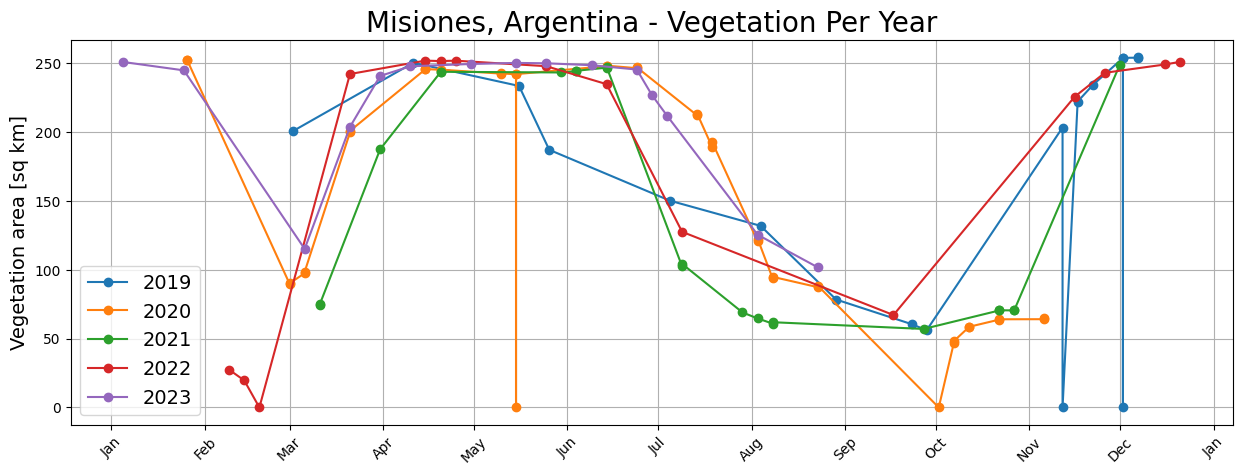

In [104]:
plt.figure(figsize=(15, 5))
plt.title("Misiones, Argentina - Vegetation Per Year", fontsize=20)
plt.xticks(rotation=45)
plt.ylabel("Vegetation area [sq km]", fontsize=14)
plt.plot(t[0], a[0], marker="o", label="2019")
plt.plot(t[1], a[1], marker="o", label="2020")
plt.plot(t[2], a[2], marker="o", label="2021")
plt.plot(t[3], a[3], marker="o", label="2022")
plt.plot(t[4], a[4], marker="o", label="2023")
# Make ticks on occurrences of each month:
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.grid("on")
plt.legend(loc="best", fontsize=14)
plt.show()

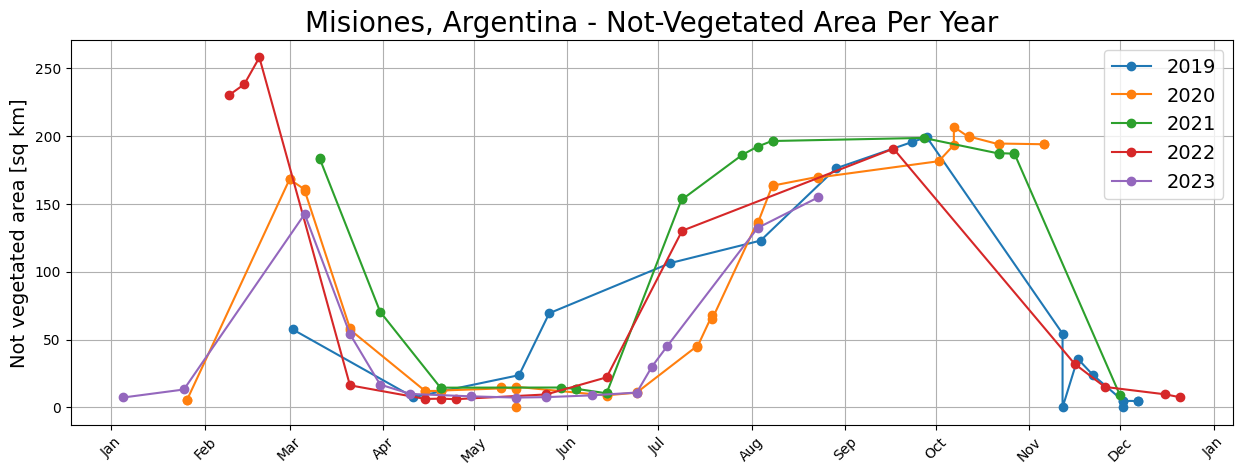

In [106]:
plt.figure(figsize=(15, 5))
plt.title("Misiones, Argentina - Not-Vegetated Area Per Year", fontsize=20)
plt.xticks(rotation=45)
plt.ylabel("Not vegetated area [sq km]", fontsize=14)
plt.plot(t[0], nt[0], marker="o", label="2019")
plt.plot(t[1], nt[1], marker="o", label="2020")
plt.plot(t[2], nt[2], marker="o", label="2021")
plt.plot(t[3], nt[3], marker="o", label="2022")
plt.plot(t[4], nt[4], marker="o", label="2023")
# Make ticks on occurrences of each month:
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.grid("on")
plt.legend(loc="best", fontsize=14)
plt.show()

We can see that both have reverse development over the year due to seasonality and no clear general trend to increase or decrease

In [97]:
frames = []
filenames = glob("./masks/land-cover-overlay/*.png")
filenames.sort()

for filename in filenames:
    frames.append(imageio.imread(filename))
imageio.mimsave("land-cover.gif", frames, duration=1)

In [100]:
HTML('<img src="./land-cover.gif">')

### The results of this analysis are not particularly accurate, so as future work we propose the use of a custom model using a semantic segmentation algorithm fine-tuned with a dataset similar to the area of interest to achieve better results.